In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pickle


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/1029_lstm_최종/data_ph.zip"
extract_folder = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [5]:

with open("/content/X_data_ph.pkl", "rb") as f:
    X = pickle.load(f)
with open("/content/y_data_ph.pkl", "rb") as f:
    y = pickle.load(f)

print(X.shape,y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)


(3758922, 10, 23) (3758922,)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization

# 모델 정의
lstm_model = Sequential()

# 첫 번째 LSTM 레이어
lstm_model.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))  # 드롭아웃 추가
lstm_model.add(BatchNormalization())  # 배치 정규화 추가

# 두 번째 LSTM 레이어
lstm_model.add(LSTM(150, return_sequences=True))
lstm_model.add(Dropout(0.2))  # 드롭아웃 추가
lstm_model.add(BatchNormalization())  # 배치 정규화 추가

# 세 번째 LSTM 레이어
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.2))  # 드롭아웃 추가
lstm_model.add(BatchNormalization())  # 배치 정규화 추가

# 출력 레이어
lstm_model.add(Dense(1, activation='linear'))

# 모델 컴파일
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약
lstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 200)           179200    
                                                                 
 dropout (Dropout)           (None, 10, 200)           0         
                                                                 
 batch_normalization (Batch  (None, 10, 200)           800       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 10, 150)           210600    
                                                                 
 dropout_1 (Dropout)         (None, 10, 150)           0         
                                                                 
 batch_normalization_1 (Bat  (None, 10, 150)           600       
 chNormalization)                                       

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# ModelCheckpoint 콜백 생성
checkpoint_filepath = '/content/drive/MyDrive/1029_lstm_최종/lstm_ph.h5'  # 모델을 저장할 파일 경로
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# EarlyStopping 콜백 생성
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,  # 5 에포크 동안 개선이 없으면 훈련 종료
    restore_best_weights=True)  # 가장 좋은 가중치로 복원



Epoch 1/30
93974/93974 [==============================] - 848s 9ms/step - loss: 22332791848960.0000 - val_loss: 15214079639552.0000
Epoch 2/30
93974/93974 [==============================] - 837s 9ms/step - loss: 6959353823232.0000 - val_loss: 880319070208.0000
Epoch 3/30
93974/93974 [==============================] - 842s 9ms/step - loss: 337127407616.0000 - val_loss: 18987589632.0000
Epoch 4/30
93974/93974 [==============================] - 847s 9ms/step - loss: 251356004352.0000 - val_loss: 10736659456.0000
Epoch 5/30
93974/93974 [==============================] - 865s 9ms/step - loss: 251416477696.0000 - val_loss: 10769530880.0000
Epoch 6/30
93974/93974 [==============================] - 872s 9ms/step - loss: 251660173312.0000 - val_loss: 18316113920.0000
Epoch 7/30
93974/93974 [==============================] - 889s 9ms/step - loss: 248011194368.0000 - val_loss: 10198220800.0000
Epoch 8/30
93974/93974 [==============================] - 873s 9ms/step - loss: 254082449408.0000 - val_

Mean Squared Error_train (MSE_train): 10367894578.291441
Root Mean Squared Error_train (RMSE_train): 101822.85882006772
Mean Absolute Error_train (MAE_train): 40604.656312592066
R-squared_train (R2_train ): 0.9984687544651341


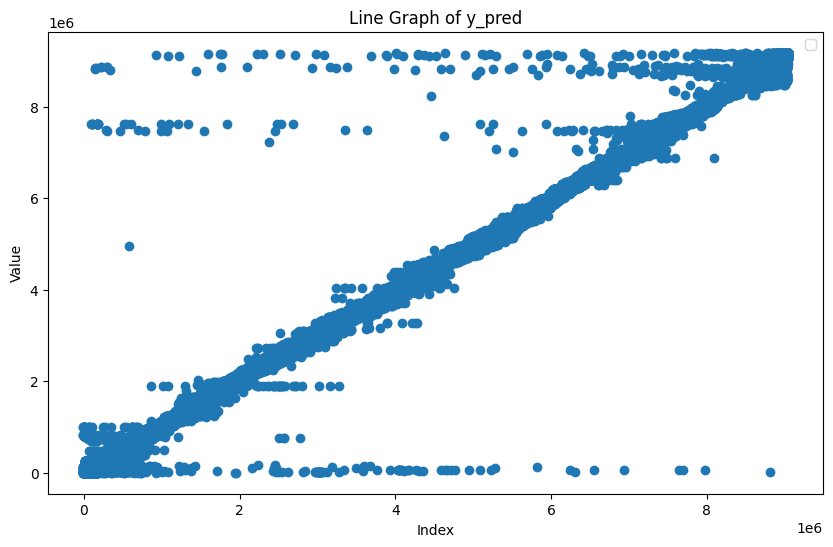

117467/117467 [==============================] - 343s 3ms/step


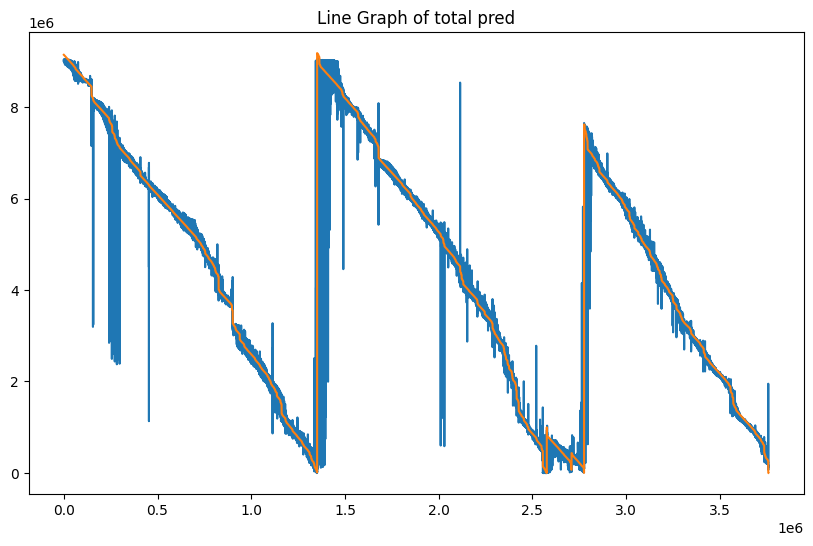

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 모델 훈련
history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[model_checkpoint_callback, early_stopping_callback])


# 가장 좋은 결과를 보인 모델 로드
lstm_model.load_weights(checkpoint_filepath)

# 테스트 데이터에 대한 예측 수행
y_pred = lstm_model.predict(X_test)

# 모델 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {np.sqrt(mse)}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2 ): {r2}')

y_train_pred = lstm_model.predict(X_train)

# train 평가
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f'Mean Squared Error_train (MSE_train): {mse_train}')
print(f'Root Mean Squared Error_train (RMSE_train): {np.sqrt(mse_train)}')
print(f'Mean Absolute Error_train (MAE_train): {mae_train}')
print(f'R-squared_train (R2_train ): {r2_train}')


# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_pred,y_test)
plt.title('Line Graph of y_pred')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

lstm_pred = lstm_model.predict(X)

# 전체 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(lstm_pred)
plt.plot(y)
plt.title('Line Graph of total pred')
plt.show()


In [7]:
checkpoint_filepath = '/content/drive/MyDrive/1029_lstm_최종/lstm_ph.h5'  # 모델을 저장할 파일 경로
lstm_model.load_weights(checkpoint_filepath)
lstm_model.save('/content/drive/MyDrive/1029_lstm_최종/lstm_ph_total.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
from keras.models import load_model

loaded_model = load_model('/content/drive/MyDrive/1029_lstm_최종/lstm_ph_total.h5')
loaded_model